## INPUT DATA IMPORT FROM KAGGLE

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'insurance-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F876734%2F1493149%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240723%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240723T213749Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3f794d48a9fbb4f42b9a1baef0f85497287a346faa31ec552043f60fc59d509f0843b3ec2824ae6e01b0395a5938572582f47ca071de76d64834f314932ce61fe65aea852eff468073a7600c395624eb91668720cdcf5afb23389ca125bd15d122fcbee41700aa6bc31a8e605747516b33cdff2cfcf5bab1518a336dbdd599a7102f0bce18fff4c90aa38f495592645194a9f7bdaa831a56be81b8855964ac62edae33ca98ca81a1019d90aa5ad559ed10da38d8b2f9fec0569946cf1dbe57695b0d041c70412c632fd329f6c5d9925c79851bd3dd7aaf3881fe1b1087677e54c0141ee8200b52c025fda467ca8202cb47ffe5df83203068c4947db8a909e75b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 13755 bytes downloaded
Downloaded and uncompressed: insurance-csv
Data source import complete.


# Introduction



In the insurance industry, accurately predicting insurance expenses is vital for effective risk assessment and claims management. Leveraging machine learning techniques can significantly enhance these processes, leading to better decision-making and improved profitability. This project focuses on predicting insurance expenses faced by policyholders using advanced data analytics.

## Background and Context

The dataset, sourced from Kaggle, includes 1,338 observations and 7 features related to policyholders, such as age, sex, BMI, children, smoker status, region, and expenses. By applying machine learning algorithms to this data, we aim to develop a predictive model that estimates insurance expenses more accurately.

## Objective

The primary objective of this project is to demonstrate the use of machine learning in predicting insurance expenses. The insights gained from this study will help improve risk assessment strategies, contributing to more accurate policy pricing and better management of insurance claims.


## Dataset Overview

The Variables in this dataset represent various aspects of a Policyholder:

* **age** - Age of the policyholder.
* **sex** - Gender of the policyholder.
* **bmi** - Body mass index of the policyholder.
* **children** - Number of children of the policyholder.
* **smoker** - Smoking status of the policyholder.
* **region** - Residential region of the policyholder.
* **expenses** - Insurance expenses incurred by the policyholder.

## Libraries & Imports

In [ ]:
# Regular libraries
import pandas as pd,os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tabulate import tabulate

# Visualization libraries
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Suppress warnings
warnings.filterwarnings('ignore')

In [ ]:
# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression # Importing LinearRegression for continuous target variable
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Section 1: Exploratory Data Analysis

In [ ]:
# Dataset View
import os;
os.listdir('/kaggle/input/')

['insurance-csv']

In [ ]:
df = pd.read_csv('/kaggle/input/insurance-csv/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


### Data Checks & Cleaning

In [ ]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


We undertake data cleaning by checking for and removing any duplicates. This is the main step for data cleaning since there are no missing values ('non-null') in the dataset to adjust.

In [ ]:
# Data Cleaning by removing duplicates
df[df.duplicated(keep=False)]
df
# Renaming cleaned dataset
insurance_main = df.drop_duplicates()
insurance_main
# Cleaned Dataset Info
insurance_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   expenses  1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


We convert the categorical columns with 'object' type to numerical columns using Label Encoding.

In [ ]:
# Converting non-numerical columns to numerical using Label Encoding
label_encoder = LabelEncoder()
df['sex'] = label_encoder.fit_transform(df['sex'])
df['smoker'] = label_encoder.fit_transform(df['smoker'])
df['region'] = label_encoder.fit_transform(df['region'])

This converts the values of each categorical column into numerical values. For example, under 'Sex' the value of 'Female' is assigned as '0', and 'Male' is '1'. Similarly for the 'Region' column, each unique value is assigned a number.

### Expenses Data Distribution & Density Exploration

We visualise different factors of the dataset through Histograms & Boxplots to understand their distribution and density.

count     1337.000000
mean     13279.121638
std      12110.359657
min       1121.870000
25%       4746.340000
50%       9386.160000
75%      16657.720000
max      63770.430000
Name: expenses, dtype: float64

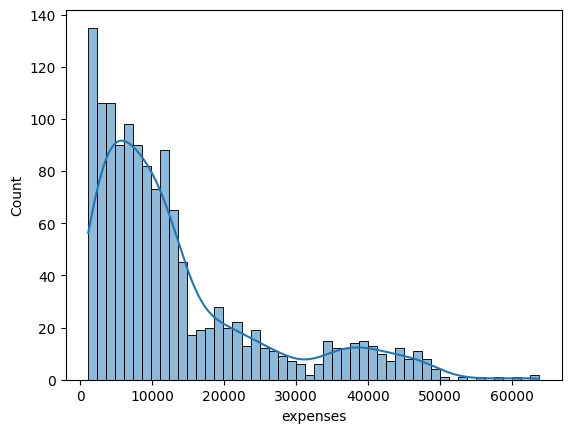

In [ ]:
# Plotting Distribution Histogram
sns.histplot(data=insurance_main, x='expenses', bins=50 ,kde=True);
insurance_main.expenses.describe()

Insurance expenses tend to be lower (0-10000 GBP) for the majority of policyholders, with fewer individuals incurring very high expenses. The right-skewed distribution suggests that a significant number of policyholders have relatively low expenses, which gradually decrease as the expense amount increases.

### Correlation

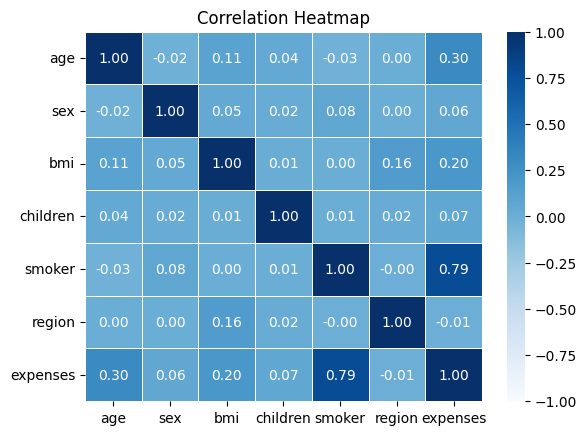

In [ ]:
# Plotting Correlation Heatmap
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

Key Insights derived from the Correlation Heatmap are as follows:
* Smoking: The most significant factor impacting insurance expenses, with a strong positive correlation (0.79). This indicates that smoking status is a major determinant of insurance costs.
* Age and BMI: Both show moderate positive correlations with expenses, suggesting that older individuals and those with higher BMI tend to have higher insurance expenses.
* Children: Children have weak correlations with all other variables, except expenses. The slight positive correlation with expenses (0.068) indicates that having more childern might lead to lower expenditure on Insurance.
* Other Variables: Factors such as sex and region show weak correlations with insurance expenses, indicating they have a lesser impact on the cost.

### EDA of Expenses based on Smoking Status

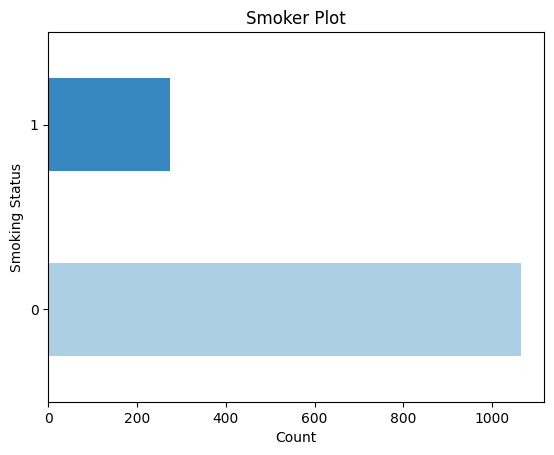

smoker
no     1063
yes     274
Name: count, dtype: int64

In [ ]:
# Smoker Data Exploration
df.groupby('smoker').size().plot(kind='barh', color=sns.color_palette('Blues', n_colors=len(df['smoker'].unique())))
plt.xlabel('Count')
plt.ylabel('Smoking Status')
plt.title('Smoker Plot')
plt.show()

insurance_main.smoker.value_counts()

In [ ]:
insurance_main.groupby('smoker')['expenses'].mean()

smoker
no      8440.660461
yes    32050.231971
Name: expenses, dtype: float64

Average Expenses for a Smoker are severely higher at £32,050.23 when compared to those of a Non-Smoker at £8,440.66.

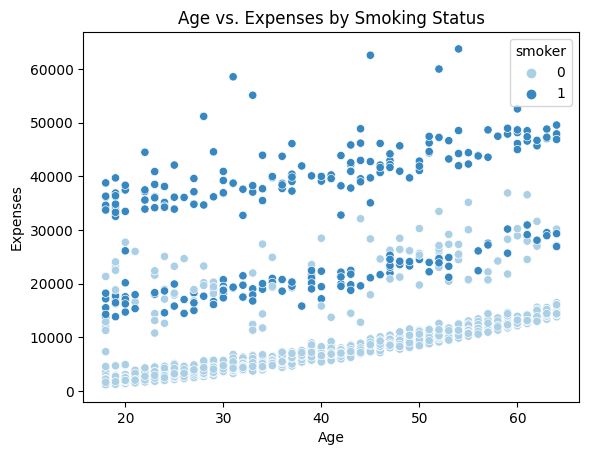

In [ ]:
# Age vs. Expenses, by Smoking Status
sns.scatterplot(x='age', y='expenses', hue='smoker', data=df, palette='Blues')
plt.xlabel('Age')
plt.ylabel('Expenses')
plt.title('Age vs. Expenses by Smoking Status')
plt.show()

Insurance Expenses steadily rise with Age, and especially are higher for a Smoker vs. Non-Smoker.

### EDA of Expenses based on Sex

sex
male      675
female    662
Name: count, dtype: int64

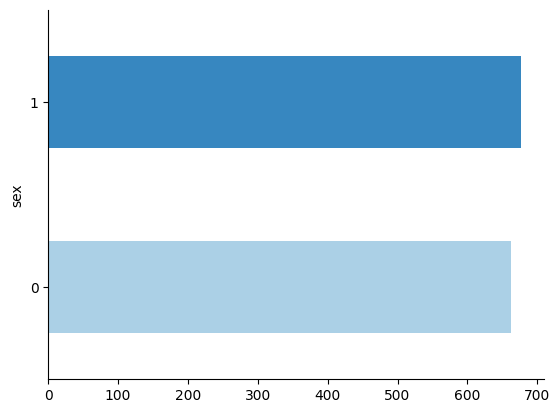

In [ ]:
# Sex Data Exploration
df.groupby('sex').size().plot(kind='barh', color=sns.palettes.mpl_palette('Blues', n_colors=2))
plt.gca().spines[['top', 'right',]].set_visible(False)

insurance_main.sex.value_counts()

In [ ]:
insurance_main.groupby('sex')['expenses'].mean()

sex
female    12569.578897
male      13974.999111
Name: expenses, dtype: float64

### EDA of Expenses based on Region

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64

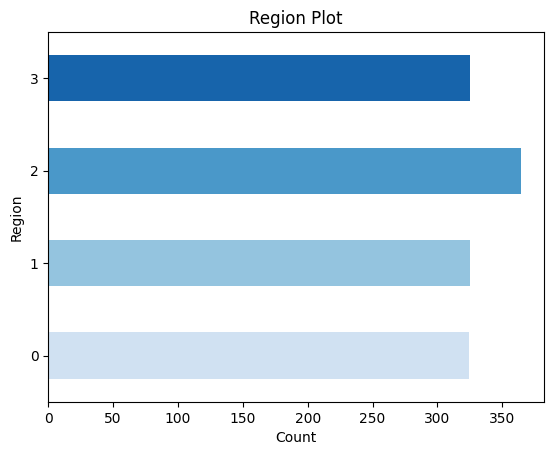

In [ ]:
# Region Data Exploration
df.groupby('region').size().plot(kind='barh', color=sns.palettes.mpl_palette('Blues', n_colors=4))
plt.xlabel('Count')
plt.ylabel('Region')
plt.title('Region Plot')

insurance_main.region.value_counts()

In [ ]:
insurance_main.groupby('region')['expenses'].mean()

region
northeast    13406.384691
northwest    12450.840648
southeast    14735.411538
southwest    12346.937908
Name: expenses, dtype: float64

Average Expenses seem to be the highest in the Southeast Region being £14,735.41.

### EDA of Expenses based on Number of Children

children
0    573
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

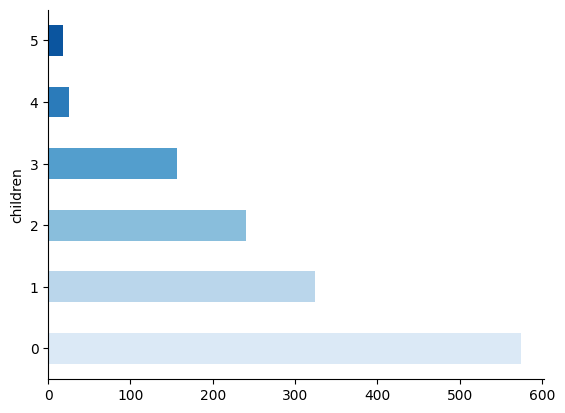

In [ ]:
# Children Data Exploration
df.groupby('children').size().plot(kind='barh', color=sns.palettes.mpl_palette('Blues', n_colors=df['children'].nunique()))
plt.gca().spines[['top', 'right',]].set_visible(False)

insurance_main.children.value_counts()

In [ ]:
insurance_main.groupby('children')['expenses'].mean()

children
0    12384.695515
1    12731.171821
2    15073.564000
3    15355.318535
4    13850.656800
5     8786.035556
Name: expenses, dtype: float64

Expenses seem to be generally increasing with the number of children up to 3 children, peaking at 3 children with an average expense of £15,355.32.


### EDA of BMI

count    1337.000000
mean       30.665520
std         6.100664
min        16.000000
25%        26.300000
50%        30.400000
75%        34.700000
max        53.100000
Name: bmi, dtype: float64

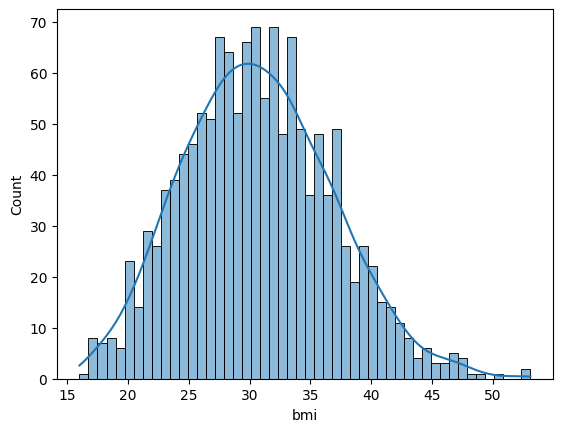

In [ ]:
# BMI Data Exploration
sns.histplot(data=insurance_main, x='bmi', bins=50, kde=True);
insurance_main.bmi.describe()

Most policyholders have a BMI between 25 and 35, indicating a central tendency around these values. The near-normal distribution suggests that BMI values are spread out in a typical bell-curve pattern, with fewer individuals having very low or very high BMI values.


<Figure size 1000x600 with 0 Axes>

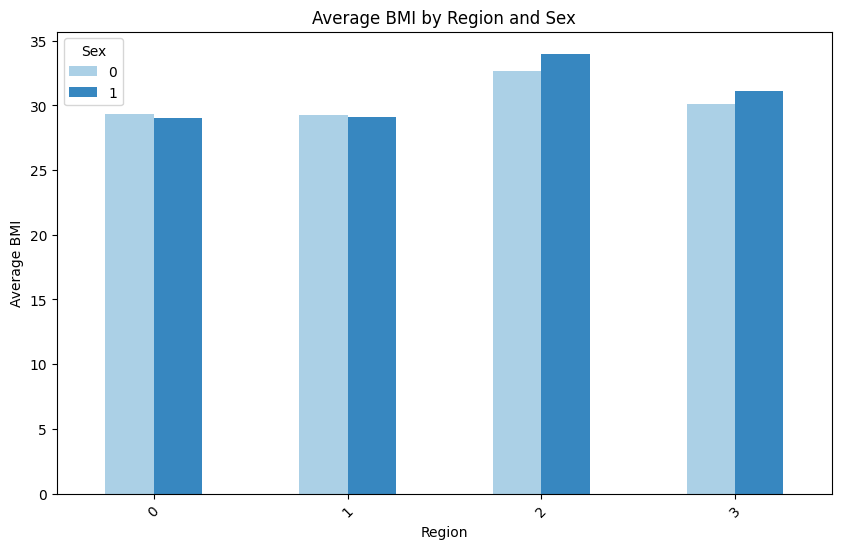

In [ ]:
# Average BMI by Region and Sex
plt.figure(figsize=(10, 6))

df_grouped = df.groupby(['region', 'sex'])['bmi'].mean().unstack()
df_grouped.plot(kind='bar', figsize=(10, 6), color=sns.color_palette('Blues', n_colors=len(df_grouped.columns)))

plt.xlabel('Region')
plt.ylabel('Average BMI')
plt.title('Average BMI by Region and Sex')
plt.xticks(rotation=45)
_ = plt.legend(title='Sex')


The Average BMI between each Sex type and Region doesn't seem to be varying too much.

# Section 2: Preparing Dataset for Analysis

In [ ]:
# Freshly reloading dataset
df = pd.read_csv("/kaggle/input/insurance-csv/insurance.csv")
df = df.drop_duplicates()

In [ ]:
# Encoding categorical variables
label_encoders = {}
for column in ['sex', 'smoker', 'region']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [ ]:
# Splitting the data into training and testing sets
X = df.drop(columns='expenses')
y = df['expenses']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

,age,sex,bmi,children,smoker,region
1114,23,1,24.5,0,0,0
968,21,1,25.7,2,0,0
599,52,0,37.5,2,0,1
170,63,1,41.5,0,0,2
275,47,0,26.6,2,0,0


In [ ]:
X_train.shape

(1069, 6)

In [ ]:
X_test.head()

,age,sex,bmi,children,smoker,region
900,49,1,22.5,0,0,0
1064,29,0,25.6,4,0,3
1256,51,0,36.4,3,0,1
298,31,1,34.4,3,1,1
237,31,1,38.4,2,0,2


In [ ]:
X_test.shape

(268, 6)

In [ ]:
y_train.head()

1114     2396.10
968      3279.87
599     33471.97
170     13405.39
275      9715.84
Name: expenses, dtype: float64

In [ ]:
y_test.head()

900      8688.86
1064     5708.87
1256    11436.74
298     38746.36
237      4463.21
Name: expenses, dtype: float64

# Section 3: Model Training



We initialise models such as Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, K-Nearest Neighbors, and Support Vector Machine, to get an overview of which algorithms work best.  

The performance of each model is evaluated using metrics like accuracy, confusion matrix, and classification report. This help us in comparing models and selecting the best-performing one.

**Our aim using these models is: Predicting Insurance Expenses.**

In [ ]:
# Initializing the models
linear_reg = LinearRegression() # Use LinearRegression for continuous target
decision_tree = DecisionTreeRegressor(random_state=42)
random_forest = RandomForestRegressor(random_state=42)
gradient_boosting = GradientBoostingRegressor(random_state=42)
knn = KNeighborsRegressor()
svm = SVR()

# Naming Models
models = [
    ('Linear Regression', linear_reg), # Replace Logistic Regression with Linear Regression
    ('Decision Tree', decision_tree),
    ('Random Forest', random_forest),
    ('Gradient Boosting', gradient_boosting),
    ('K-Nearest Neighbors', knn),
    ('Support Vector Machine', svm)
]

# Training and evaluating each model
for model_name, model in models:
    # Training the model
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)

    # Evaluating the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Printing the results
    print(f"{model_name} Results:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.2f}")
    print("\n")

Linear Regression Results:
Mean Squared Error: 35496521.90
R² Score: 0.81


Decision Tree Results:
Mean Squared Error: 40993128.14
R² Score: 0.78


Random Forest Results:
Mean Squared Error: 21558321.62
R² Score: 0.88


Gradient Boosting Results:
Mean Squared Error: 18971317.72
R² Score: 0.90


K-Nearest Neighbors Results:
Mean Squared Error: 175983969.76
R² Score: 0.04


Support Vector Machine Results:
Mean Squared Error: 208461542.37
R² Score: -0.13




Insights from Model Fitting:
* **Best Performers:** Gradient Boosting Regressor with a R-squared score of 90% followed by the Random Forest Regressor with a score of 88%. This indicates that these models explain about 90% & 88% of the variance in the dataset respectively. This is because Gradient Boosting builds multiple small models in sequence, each correcting the errors of the previous one, leading to highly accurate predictions. Both these models effectively reduce overfitting and capture complex patterns through the combination of multiple models.
* **Moderate Performance:** Linear Regression and Decision Tree Regressor, with Linear Regression (81%) slightly outperforming the Decision Tree (78%). These models are good but not as accurate because they either assume simple relationships or can become too specific to the training data.
* **Poor Performers:** K-Nearest Neighbors Regressor and Support Vector Machine Regressor, both showing very high errors and low R² scores of 4% & a whopping -13%. These models do not perform well because they either rely too much on close neighbors or need more fine-tuning and don't fit the data well.

These results suggest that ensemble methods like Gradient Boosting and Random Forest are highly effective for predicting insurance expenses in this dataset. Conversely, K-Nearest Neighbors and Support Vector Machine are not suitable for this specific problem in their current implementations.

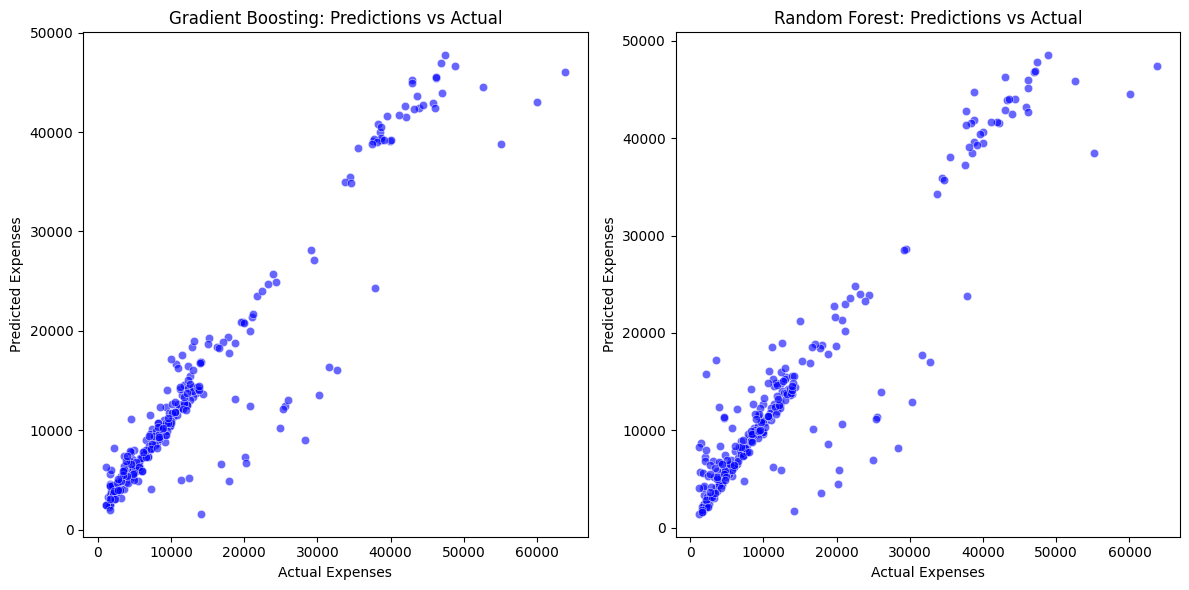

In [ ]:
# Predictions vs. Actuals Check
y_pred_gb = gradient_boosting.predict(X_test)
y_pred_rf = random_forest.predict(X_test)

# Plotting predictions vs actual for Gradient Boosting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_gb, color='blue', alpha=0.6)
plt.xlabel('Actual Expenses')
plt.ylabel('Predicted Expenses')
plt.title('Gradient Boosting: Predictions vs Actual')

# Plotting predictions vs actual for Random Forest
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_rf, color='blue', alpha=0.6)
plt.xlabel('Actual Expenses')
plt.ylabel('Predicted Expenses')
plt.title('Random Forest: Predictions vs Actual')

plt.tight_layout()
plt.show()

Both models seem to perform reasonably well in predicting expenses, with Gradient Boosting showing slightly better accuracy.
Both models have some outliers where the predictions are far off from the actual expenses.

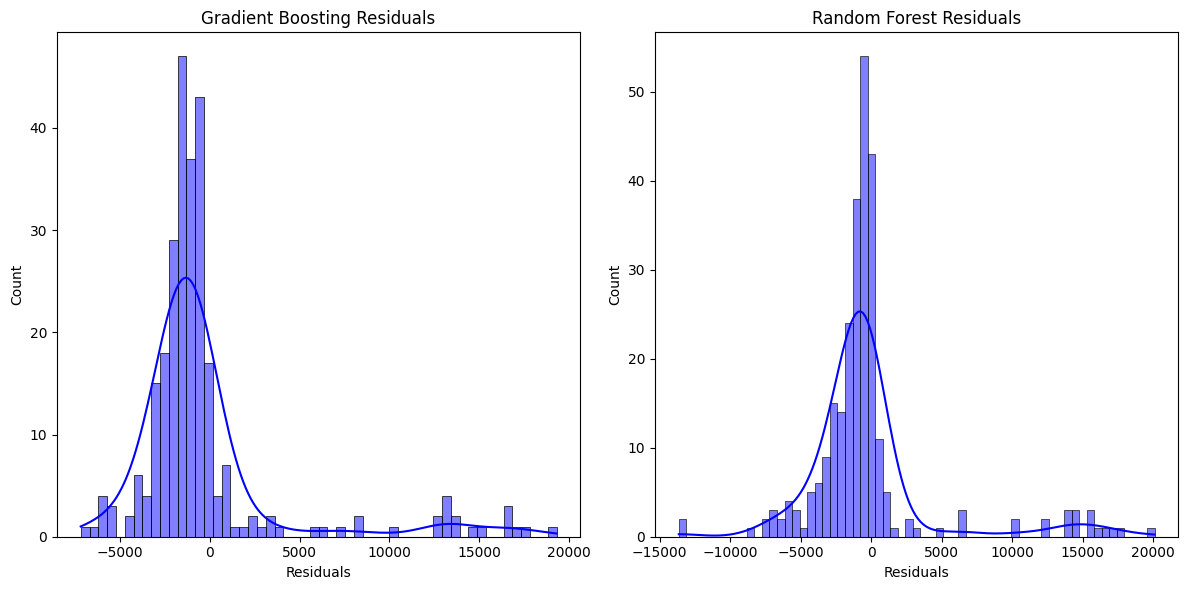

In [ ]:
# Computing Residuals
residuals_gb = y_test - y_pred_gb
residuals_rf = y_test - y_pred_rf

# Plotting residuals for Gradient Boosting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals_gb, kde=True, color='blue')
plt.xlabel('Residuals')
plt.title('Gradient Boosting Residuals')

# Plotting residuals for Random Forest
plt.subplot(1, 2, 2)
sns.histplot(residuals_rf, kde=True, color='blue')
plt.xlabel('Residuals')
plt.title('Random Forest Residuals')

plt.tight_layout()
plt.show()

Key Observations we gather from the Residuals Distribution Plot:

* Shape of the Distribution: Both histograms exhibit a roughly bell-shaped curve, suggesting that the residuals for both models might be normally distributed.

* Center: The center of both distributions appears to be close to zero. This is expected, as residuals should ideally sum to zero.

* Spread: The Random Forest model seems to have a slightly wider spread of residuals compared to Gradient Boosting. This implies that the Random Forest model's predictions have a larger variability or error compared to Gradient Boosting. This plot reinforces our R-squared score results for these models.

* Outliers: Both plots show some outliers.

These lead us to the following conclusions:

1. **Gradient Boosting:** Generally performs better in terms of prediction accuracy, as evidenced by the narrower distribution of residuals. This means its predictions are closer to the actual values on average.

2. **Random Forest:** While still showing a relatively good distribution, the wider spread indicates that its predictions are more scattered around the actual values. This might suggest that Random Forest is less consistent in its predictions.

In [ ]:
# Identifying Feature Importances
gb_importances = gradient_boosting.feature_importances_
rf_importances = random_forest.feature_importances_
features = X.columns

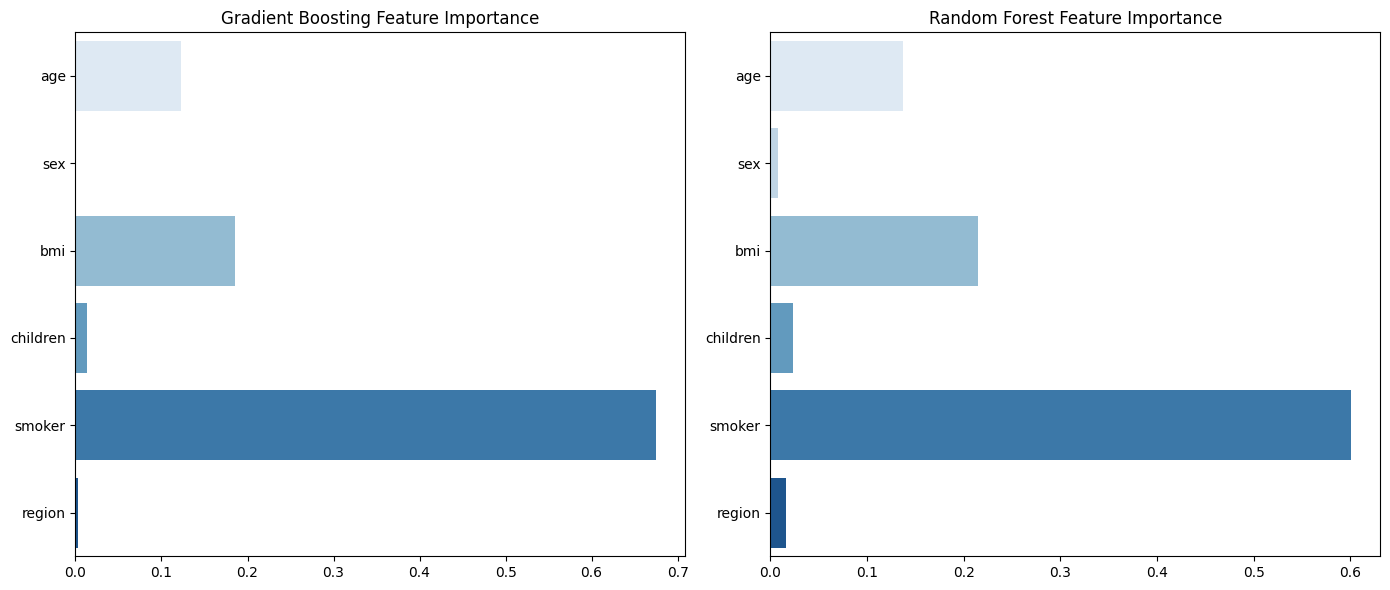

In [ ]:
# Plotting feature importance for Gradient Boosting
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=gb_importances, y=features, palette='Blues')
plt.title('Gradient Boosting Feature Importance')

# Plotting feature importance for Random Forest
plt.subplot(1, 2, 2)
sns.barplot(x=rf_importances, y=features, palette='Blues')
plt.title('Random Forest Feature Importance')

plt.tight_layout()
plt.show()

As observed earlier with the EDA, we see **Smoking Status** to be the most important feature for both our top performing models. This is followed by a policy buyer's BMI & Age.

# Section 4: Model Evaluation

In [ ]:
# Defining new input data
new_input = pd.DataFrame({
    'age': [29],
    'sex': [1],  # Assuming 1 for male after label encoding
    'bmi': [24.5],
    'children': [2],
    'smoker': [0],  # Assuming 0 for non-smoker after label encoding
    'region': [1]   # Assuming 1 for a certain region after label encoding
})

# Scaling new input data
scaler = StandardScaler()
scaler.fit(new_input)
new_input_scaled = scaler.transform(new_input)

# Predicting using Gradient Boosting and Random Forest models
prediction_gb = gradient_boosting.predict(new_input_scaled)
prediction_rf = random_forest.predict(new_input_scaled)

# Decoding categorical values back to original labels
decoded_sex = label_encoders['sex'].inverse_transform(new_input['sex'])
decoded_smoker = label_encoders['smoker'].inverse_transform(new_input['smoker'])
decoded_region = label_encoders['region'].inverse_transform(new_input['region'])

# Printing formatted results
print("\nPredictions for New Input:")
print(f"For a {decoded_sex[0].lower()} aged {new_input['age'][0]} with a BMI of {new_input['bmi'][0]} "
      f"from the {decoded_region[0]} region, having {new_input['children'][0]} children and being "
      f"{'a smoker' if decoded_smoker[0] == 1 else 'not a smoker'}, we have:")

print(f"Under Gradient Boosting model, the predicted insurance expenses will be £ {prediction_gb[0]:,.2f} (GBP).")
print(f"Under Random Forest model, the predicted insurance expenses will be £ {prediction_rf[0]:,.2f} (GBP).")


Predictions for New Input:
For a male aged 29 with a BMI of 24.5 from the northwest region, having 2 children and being not a smoker, we have:
Under Gradient Boosting model, the predicted insurance expenses will be £ 2,749.13 (GBP).
Under Random Forest model, the predicted insurance expenses will be £ 2,943.02 (GBP).
